In [1]:
# Import required libraries
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageOps

# Computer Vision: Image Filtering with PyTorch

This notebook demonstrates image filtering techniques using PyTorch's convolutional layers, including:
- Loading and preprocessing images
- Applying binomial (blur) filters
- Implementing Sobel edge detection (Gx and Gy filters)

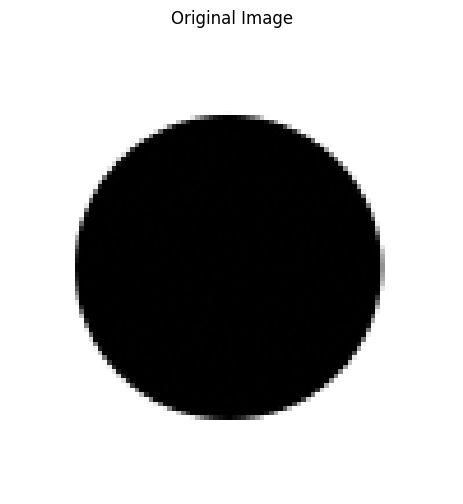

In [2]:
# Load and display the image
img = Image.open("SchwarzerKreis.png")
img = ImageOps.grayscale(img)
plt.figure(figsize=(8, 6))
plt.imshow(img, cmap='gray')
plt.title('Original Image')
plt.axis('off')
plt.show()

In [3]:
# Create convolutional layer
conv2d = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, stride=1, 
                   padding=1, dilation=1, bias=False, padding_mode='replicate')
print("Initial state dict:", conv2d.state_dict())

Initial state dict: OrderedDict([('weight', tensor([[[[ 0.2565,  0.1298, -0.0490],
          [-0.2079, -0.2272, -0.0850],
          [-0.1221,  0.3239,  0.2819]]]]))])


Erstellt eine 2D-Faltungsschicht (Convolutional Layer) in PyTorch
- ```in_channels=1``` - Erwartet 1 Eingangskanal (Graustufenbild)
- ```out_channels=1``` - Erzeugt 1 Ausgangskanal (ein gefiltertes Bild)
- ```kernel_size=3``` - Verwendet einen 3×3 Filter/Kernel
- ```stride=1``` - Bewegt den Filter jeweils 1 Pixel weiter (kein Überspringen)
- ```padding=1``` - Fügt einen 1-Pixel-Rand um das Bild hinzu, um die Dimensionen beizubehalten
- ```dilation=1``` - Keine Abstände zwischen Kernel-Elementen (Standard-Faltung)
- ```bias=False``` - Kein Bias-Term wird hinzugefügt (nur die Filtergewichte werden angewendet)
- ```padding_mode='```replicate' - Füllt das Padding durch Wiederholung der Randpixel (anstatt Nullen)

# Dilation

Bestimmt den Abstand zwischen Kernel-Elementen

```dilation=1``` (Standard): Keine Abstaende

```
[X][X][X]
[X][X][X]
[X][X][X]
```

Ideal fuer praezise Filter wie Binominial und Sobel

```dilation=2```: 1 Pixel Abstand zwischen den Kernel-Elementen
```
[X][ ][X][ ][X]
[ ][ ][ ][ ][ ]
[X][ ][X][ ][X]
[ ][ ][ ][ ][ ]
[X][ ][X][ ][X]
```

Ideal fuer groessere Strukuren

In [4]:
# Define filter kernels
GxWeights = np.array([[-0.25, 0, 0.25],
                      [-0.50, 0, 0.50],
                      [-0.25, 0, 0.25]], np.float32)



GyWeights = np.array([[-0.25, -0.50, -0.25],
                      [ 0,     0,    0],
                      [ 0.25,  0.50, 0.25]], np.float32)

# Sum should be 0.0
print(GyWeights.sum())
print(GyWeights.sum())

BinomialWeights = np.array([[0.0625, 0.125, 0.0625],
                            [ 0.125, 0.250, 0.125],
                            [ 0.0625, 0.125, 0.0625]], np.float32)

# Sum should be 1.0 for normalization
print(BinomialWeights.sum())

print("Gx Filter (horizontal edges):")
print(GxWeights)
print("\nGy Filter (vertical edges):")
print(GyWeights)
print("\nBinomial Filter (blur):")
print(BinomialWeights)

0.0
0.0
1.0
Gx Filter (horizontal edges):
[[-0.25  0.    0.25]
 [-0.5   0.    0.5 ]
 [-0.25  0.    0.25]]

Gy Filter (vertical edges):
[[-0.25 -0.5  -0.25]
 [ 0.    0.    0.  ]
 [ 0.25  0.5   0.25]]

Binomial Filter (blur):
[[0.0625 0.125  0.0625]
 [0.125  0.25   0.125 ]
 [0.0625 0.125  0.0625]]


# Sobel-Gradient-Erklärung

Die beiden Sobel-Kernel `GxWeights` und `GyWeights` approximieren die **partiellen Ableitungen** (Gradienten) eines Graustufenbildes in x- (horizontal) und y-Richtung (vertikal).

Warum Gradient? Ein Bild kann man als Funktion \(I(x,y)\) auffassen, die jedem Pixel seine Intensität (Helligkeit) zuordnet. Der (2D) Gradient dieser Funktion ist:

```
∇I = ( ∂I/∂x , ∂I/∂y )
```

- `∂I/∂x` misst, wie stark sich die Helligkeit horizontal ändert.
- `∂I/∂y` misst, wie stark sie sich vertikal ändert.

Sobel-Kernel liefern genau diese Schätzungen durch **diskrete Faltung** mit passenden Gewichtsmustern:

```
Gx (horizontal):   Gy (vertikal):
[-1  0  1]          [-1 -2 -1]
[-2  0  2]          [ 0  0  0]
[-1  0  1]          [ 1  2  1]
```
(In deiner Variante sind die Werte nur skaliert / normalisiert, das Verhältnis bleibt gleich.)

Die Struktur besteht aus zwei Teilen:
1. Differenz links vs. rechts (oder oben vs. unten) → Ableitungsanteil
2. Gewichtung mit stärkeren Werten in der Mitte (Zeile/Spalte mit -2 / 2) → Leichte Glättung (ähnlich einem kleinen Binomial/Gauss) zur Rauschunterdrückung

Ergebnis der Faltung:
- Faltung mit `GxWeights` ≈ Schätzung von `∂I/∂x`
- Faltung mit `GyWeights` ≈ Schätzung von `∂I/∂y`

Aus beiden kannst du weitere Größen ableiten:

1. Gradient-Betrag (Kantenstärke):
```
|∇I| = sqrt( (∂I/∂x)^2 + (∂I/∂y)^2 )
```
2. Gradient-Richtung (Orientierung der Kante):
```
θ = arctan( (∂I/∂y) / (∂I/∂x) )
```

Warum geben sie Kanten? An einer Kante ändert sich die Helligkeit abrupt → Ableitung groß → Sobel-Antwort groß. In flachen Regionen (konstant) → Ableitung ≈ 0.

Warum nicht einfache Differenzen? Reine zentrale Differenzen wären empfindlicher gegenüber Rauschen. Sobel kombiniert Ableitung + leichte Glättung (Filter ist wie: Ableitung von einem leicht geglätteten Bild).

Unterschied zu Prewitt / Scharr:
- Prewitt: ähnliche Struktur, aber ohne stärkere Mittelgewichtung (etwas schlechtere Rotationssymmetrie)
- Scharr: optimierte Koeffizienten für bessere isotrope Kantenerkennung (für präzisere Richtung)

Skalierung deiner Kernel:
Die Faktoren (-0.25, -0.50, 0.50, usw.) sind nur normierte Varianten derselben relativen Muster. Skalierung ändert nur die absoluten Werte, nicht die Lage der Kanten.

Zusammenfassung:
- Sobel = diskrete Approximation der partiellen Ableitungen
- Liefert Richtungsinformationen und Stärke des Gradienten
- Grundlage für viele weitere Schritte (Kantendetektion, Canny, Feature-Extraktion)

Als nächster Schritt könntest du auch den Winkel berechnen und als Farbkarte darstellen (Hue = Richtung, Value = Betrag).

In [5]:
# Helper function to set weights in convolutional layer
def WeightsToStateDict(weight, conv2d):
    """
    Helper function to load weights into a convolutional layer
    """
    weight = torch.from_numpy(weight)
    weight = torch.unsqueeze(torch.unsqueeze(weight, dim=0), dim=0)
    state_dict = conv2d.state_dict()
    state_dict['weight'] = weight
    conv2d.load_state_dict(state_dict)

``weight = torch.from_numpy(weight)``  
Macht aus einem NumPy-Array ein PyTorch Tensor

``weight = torch.unsqueeze(torch.unsqueeze(weight, dim=0), dim=0)``  
Fuegt 2 zusaetzliche Dimensionen zum Tensor hinzu:
- Vorher: (3, 3)
- Nachher: (1, 1, 3, 3)
    - 1 = 1 Ausgangskanal (out_channels)
    - 1 = 1 Eingangskanal (in_channels, Graustufenbild)
    - 3 = Kernel-Höhe
    - 3 = Kernel-Breite

``state_dict = conv2d.state_dict()``  
Erzeugt ein State Dictonary (Zustandswoerterbuch) der Convolutional Layer. PyTorch benoetigt ein State Dictonary ``conv2d.load_state_dict(state_dict)`` um trainierbare Parameter zu verwalten. (In PyTorch sind die Parameter spezielle Objekte).
So koennen:
- Gewichte gesetzt werden: ``state_dict['weight'] = weight``
- Modell/Gewichte gespeichert werden: ``torch.save(model.state_dict(), 'model.pth')``
- Modell/Gewichte geladen werden: ``model.load_state_dict(torch.load('model.pth'))``
- Checkpoints und Resume Training:
    ``` 
    checkpoint = 
    {
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'epoch': epoch
    }
    torch.save(checkpoint, 'checkpoint.pth')
    ```

``state_dict['weight'] = weight``  
Setzt das Gewicht der state dictonary mit dem gegeben Gewicht.

``conv2d.load_state_dict(state_dict)``


In [6]:
v = np.array([1,2,1])
numpy_weight = np.outer(v, v)/16
print(numpy_weight)

torch_weight = torch.from_numpy(numpy_weight)
print(torch_weight)

torch_weight = torch.unsqueeze(torch_weight, dim=0).unsqueeze(dim=0)
print(torch_weight)

print("\n--- Visualisierung der Dimensionen ---")
print(f"Vorher (2D): Shape = (3, 3)")
print(f"Nachher (4D): Shape = (1, 1, 3, 3)")
print("\nBedeutung der Dimensionen:")
print("  [                                ← Dimension 0 (out_channels=1)")
print("    [                              ← Dimension 1 (in_channels=1)")
print("      [                            ← Dimension 2 (height=3)")
print("        [0.0625, 0.125, 0.0625],  ← Dimension 3 (width=3)")
print("        [0.125,  0.250, 0.125 ],")
print("        [0.0625, 0.125, 0.0625]")
print("      ]")
print("    ]")
print("  ]")

state_dict = conv2d.state_dict()
print("\n--- State Dict der Convolutional Layer ---")
print(state_dict['weight'])


[[0.0625 0.125  0.0625]
 [0.125  0.25   0.125 ]
 [0.0625 0.125  0.0625]]
tensor([[0.0625, 0.1250, 0.0625],
        [0.1250, 0.2500, 0.1250],
        [0.0625, 0.1250, 0.0625]], dtype=torch.float64)
tensor([[[[0.0625, 0.1250, 0.0625],
          [0.1250, 0.2500, 0.1250],
          [0.0625, 0.1250, 0.0625]]]], dtype=torch.float64)

--- Visualisierung der Dimensionen ---
Vorher (2D): Shape = (3, 3)
Nachher (4D): Shape = (1, 1, 3, 3)

Bedeutung der Dimensionen:
  [                                ← Dimension 0 (out_channels=1)
    [                              ← Dimension 1 (in_channels=1)
      [                            ← Dimension 2 (height=3)
        [0.0625, 0.125, 0.0625],  ← Dimension 3 (width=3)
        [0.125,  0.250, 0.125 ],
        [0.0625, 0.125, 0.0625]
      ]
    ]
  ]

--- State Dict der Convolutional Layer ---
tensor([[[[ 0.2565,  0.1298, -0.0490],
          [-0.2079, -0.2272, -0.0850],
          [-0.1221,  0.3239,  0.2819]]]])


## Apply Binomial Filter (Blur)

In [7]:
# Apply binomial filter to blur the image
weight = torch.unsqueeze(torch.unsqueeze(torch.from_numpy(BinomialWeights), dim=0), dim=0)
weight = torch.from_numpy(BinomialWeights).unsqueeze(dim=0).unsqueeze(dim=0)

state_dict = conv2d.state_dict()
state_dict['weight'] = weight
conv2d.load_state_dict(state_dict)

<All keys matched successfully>

## Apply Sobel Edge Detection

In [8]:
# Image transformation
transform = transforms.ToTensor()
# Apply the filter
imgBlured = conv2d(transform(img))

``transform = transforms.ToTensor()`` erstellt eine Transformation von PIL-Bild (Pillow Lib) zu PyTorch-Tensor.

- Aus NumPy-Array Werte (0-255) werden Normalisierte Werte (0.0 - 1.0)
- Dimensionen werden angepasst: (Höhe, Breite) -> (Kanäle, Höhe, Breite)

Verwendung ueber ``imgBlured = conv2d(transform(img))``

torch.Size([1, 100, 96])
torch.Size([100, 96, 1])


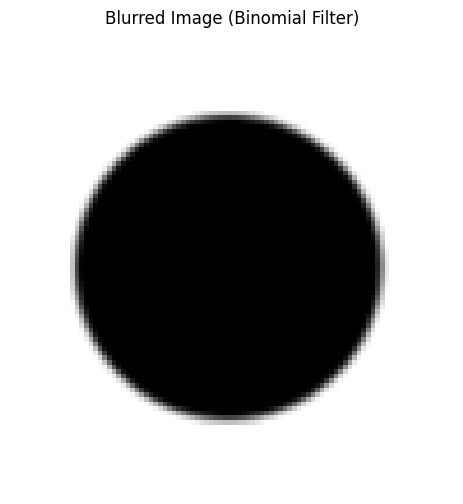

In [9]:
# Display the blurred image
print(imgBlured.shape)
result = imgBlured.permute(1, 2, 0)
print(result.shape)
plt.figure(figsize=(8, 6))
plt.imshow(result.detach().numpy(), cmap='gray')
plt.title('Blurred Image (Binomial Filter)')
plt.axis('off')
plt.show()

``result.detach().numpy()``  
Erstellt eine Kopie des Tensors ohne Gradient-Information (entfernt das Gradient-Tracking von PyTorch) und konvertiert es in ein Numpy Array.

 Gradient-Tracking ist PyTorchs eingebauetes System um Berechnungsgraphen zu verfolgen um damit dann automatisch Gradienten zu berechnen beim Trainieren (Backpropagation).

``result = imgBlured.permute(1, 2, 0)``  
Aendert die Reihenfolge der Dimensionen. "Vom Urspruenglichen Shape Zuerst Dimension 1, dann Dimension 2, dann Dimension 0"
- Vorher:   
    ``print(imgBlured.shape)``   
    --> ``torch.Size([1, 100, 96])``  
- Nachher:   
    ``print(result.shape)``  
    --> ``torch.Size([100, 96, 1])``  

PyTorch: Verwendet (Kanäle, Höhe, Breite) - "Channel First"  
Matplotlib: Erwartet (Höhe, Breite, Kanäle) - "Channel Last"

In [10]:
# Apply binomial filter to blur the image
weight = torch.unsqueeze(torch.unsqueeze(torch.from_numpy(BinomialWeights), dim=0), dim=0)
weight = torch.from_numpy(BinomialWeights).unsqueeze(dim=0).unsqueeze(dim=0)

state_dict = conv2d.state_dict()
state_dict['weight'] = weight
conv2d.load_state_dict(state_dict)

<All keys matched successfully>

In [11]:
# Combine Gx and Gy weights for simultaneous edge detection
weights = np.zeros((2, 3, 3))
print(weights)
weights[0, :, :] = GxWeights  # Horizontal edge detection
weights[1, :, :] = GyWeights  # Vertical edge detection

print(weights)

print("Combined weights shape:", weights.shape)
print("Gx weights (channel 0):")
print(weights[0])
print("Gy weights (channel 1):")
print(weights[1])

[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]]
[[[-0.25  0.    0.25]
  [-0.5   0.    0.5 ]
  [-0.25  0.    0.25]]

 [[-0.25 -0.5  -0.25]
  [ 0.    0.    0.  ]
  [ 0.25  0.5   0.25]]]
Combined weights shape: (2, 3, 3)
Gx weights (channel 0):
[[-0.25  0.    0.25]
 [-0.5   0.    0.5 ]
 [-0.25  0.    0.25]]
Gy weights (channel 1):
[[-0.25 -0.5  -0.25]
 [ 0.    0.    0.  ]
 [ 0.25  0.5   0.25]]


In [12]:
# Create new convolutional layer with 2 output channels (Gx and Gy)
conv2d_sobel = nn.Conv2d(in_channels=1, out_channels=2, kernel_size=3, stride=1, 
                         padding=1, dilation=1, bias=False, padding_mode='replicate')

# Load the Sobel weights
state_dict = conv2d_sobel.state_dict()
state_dict['weight'] = torch.unsqueeze(torch.from_numpy(weights), dim=1)
conv2d_sobel.load_state_dict(state_dict)

# Apply Sobel filters to the blurred image
imgSobel = conv2d_sobel(imgBlured)
print("Sobel output shape:", imgSobel.shape)

Sobel output shape: torch.Size([2, 100, 96])


``torch.unsqueeze(torch.from_numpy(weights), dim=1)``  
``weights`` hat 2 Kernel, also bereits die shape (2, 3, 3). Wir brauchen aber ``(out_channels, in_channels, height, width)``. Deshalb an der Position 1 (also 2.) eine Dimension mehr. 

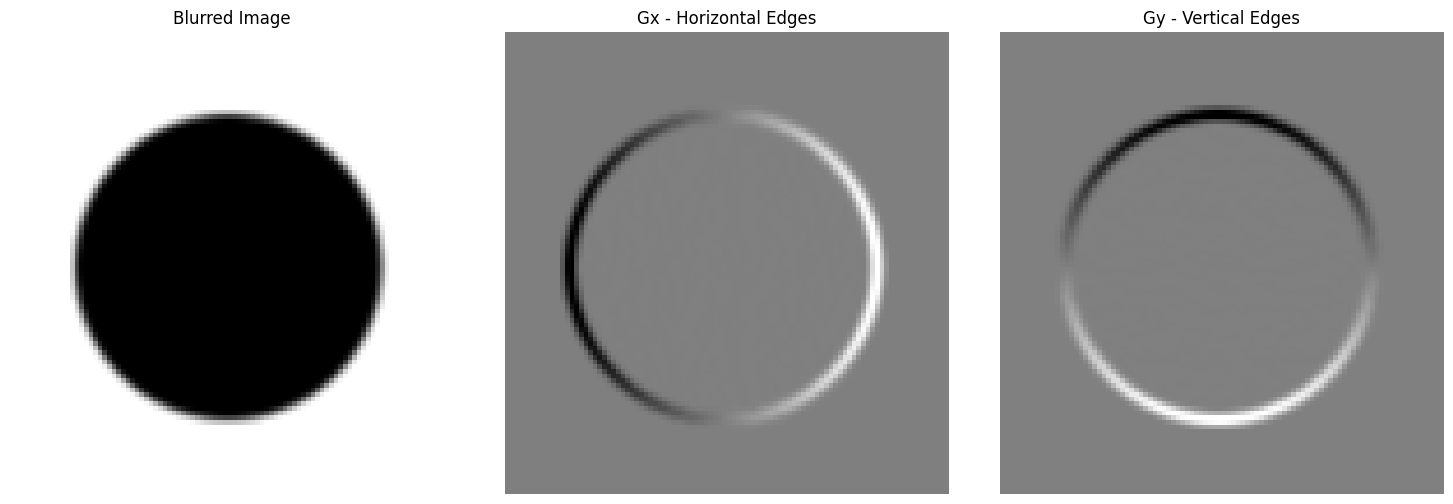

In [13]:
# Plot Gx and Gy edge detection results
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Original blurred image
axes[0].imshow(imgBlured.squeeze().detach().numpy(), cmap='gray')
axes[0].set_title('Blurred Image')
axes[0].axis('off')

# Gx (horizontal edges)
axes[1].imshow(imgSobel[0].detach().numpy(), cmap='gray')
axes[1].set_title('Gx - Horizontal Edges')
axes[1].axis('off')

# Gy (vertical edges)
axes[2].imshow(imgSobel[1].detach().numpy(), cmap='gray')
axes[2].set_title('Gy - Vertical Edges')
axes[2].axis('off')

plt.tight_layout()
plt.show()

imgSobel shape: (2, 100, 96)
gx shape: (100, 96)
gy shape: (100, 96)
magnitude shape: (100, 96)


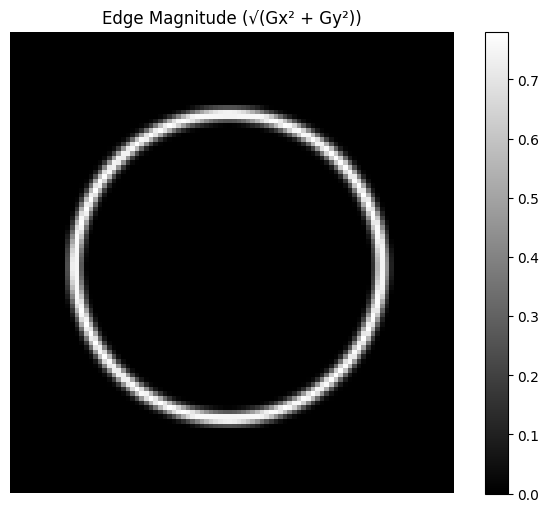

Edge magnitude range: 0.000 to 0.781


In [17]:
# Calculate gradient magnitude (combined edge strength)
# Ziel: Robust gegen unterschiedliche Shapes (mit oder ohne Batch-Dimension)
# Erwartbare Shapes:
#  - (2, H, W)           -> keine Batch-Dimension, nur 2 Kanäle (Gx, Gy)
#  - (1, 2, H, W)        -> Batch=1, 2 Kanäle
#  - (N, 2, H, W)        -> Allgemein

shape = tuple(imgSobel.shape)
print(f"imgSobel shape: {shape}")

if len(shape) == 3:
    # (2, H, W) → Kanäle direkt
    assert shape[0] == 2, "Erwarte 2 Kanäle für Sobel (Gx, Gy)"
    gx_tensor = imgSobel[0]
    gy_tensor = imgSobel[1]
elif len(shape) == 4:
    # (N, 2, H, W)
    assert shape[1] == 2, "Erwarte 2 Kanäle entlang Dimension 1 für Sobel (Gx, Gy)"
    gx_tensor = imgSobel[0, 0]
    gy_tensor = imgSobel[0, 1]
else:
    raise ValueError(f"Unerwartete Shape für imgSobel: {shape}")

# In NumPy umwandeln
gx = gx_tensor.detach().cpu().numpy()
gy = gy_tensor.detach().cpu().numpy()

print(f"gx shape: {gx.shape}")
print(f"gy shape: {gy.shape}")

# Sicherstellen, dass beide 2D sind
if gx.ndim != 2 or gy.ndim != 2:
    raise ValueError(f"Erwarte 2D Arrays für gx/gy, bekam gx.ndim={gx.ndim}, gy.ndim={gy.ndim}")

magnitude = np.sqrt(gx**2 + gy**2)
print(f"magnitude shape: {magnitude.shape}")

# Anzeige
plt.figure(figsize=(8, 6))
plt.imshow(magnitude, cmap='gray')
plt.title('Edge Magnitude (√(Gx² + Gy²))')
plt.axis('off')
plt.colorbar()
plt.show()

print(f"Edge magnitude range: {magnitude.min():.3f} to {magnitude.max():.3f}")
